In [1]:
# 📌 STEP 1: Install dependencies
!pip install --upgrade tensorflow matplotlib

In [2]:
# 📌 STEP 2: Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
from IPython.display import Image, display

In [3]:
# 📌 STEP 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# 📌 STEP 4: Set Dataset Path (update if needed)
import os

# Set dataset base directory (change path if needed)
data_dir = "/content/drive/MyDrive/fer2013"

# Define paths for training and testing
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

# ✅ Get list of class folder names from training data
classes = sorted(os.listdir(train_path))  # sorted for consistency
num_classes = len(classes)

print(f"Detected {num_classes} emotion classes:", classes)

Detected 7 emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [15]:
# 📌 STEP 5: Preview folders in dataset
print("Train classes:", os.listdir(train_path))
print("Test classes:", os.listdir(test_path))

Train classes: ['disgust', 'surprise', 'fear', 'angry', 'neutral', 'sad', 'happy']
Test classes: ['fear', 'neutral', 'angry', 'disgust', 'surprise', 'happy', 'sad']


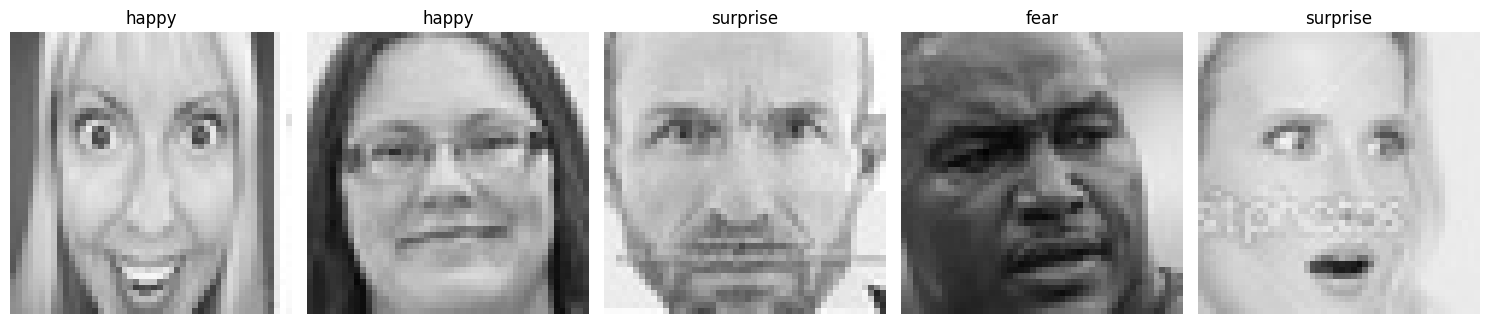

In [16]:
# 📌 STEP 6: Show random sample images
def show_random_images(folder, n=5):
    emotions = os.listdir(folder)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        emotion = random.choice(emotions)
        emotion_path = os.path.join(folder, emotion)
        image_name = random.choice(os.listdir(emotion_path))
        image_path = os.path.join(emotion_path, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(emotion)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Uncomment to preview
show_random_images(train_path, n=5)

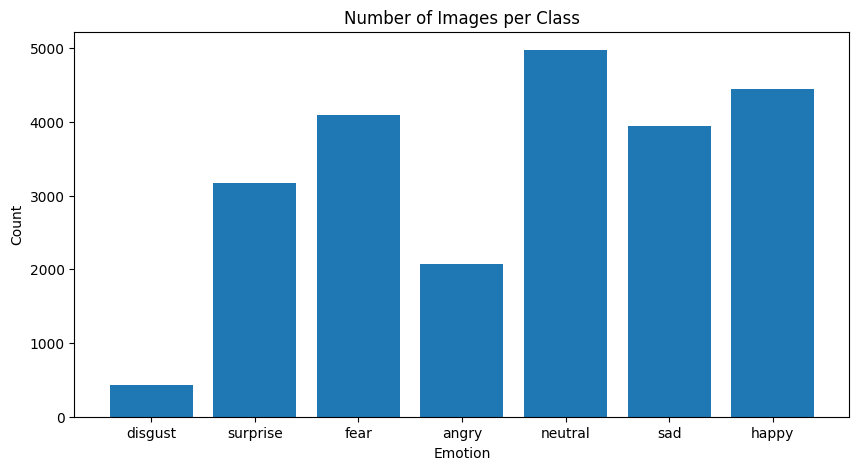

In [17]:
# 📌 STEP 7: Visualize training samples
classes = os.listdir(train_path)
class_counts = {}
for emotion in classes:
    class_path = os.path.join(train_path, emotion)
    class_counts[emotion] = len(os.listdir(class_path))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images per Class')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [18]:
# 🛠 STEP 8: Data Loading & Augmentation
img_height, img_width = 48, 48
batch_size = 256  # Updated batch size

# Load training data (converted to RGB)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",  # updated to 3-channel
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",  # updated to 3-channel
    shuffle=False
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment_images(images, labels):
    return data_augmentation(images), labels

train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

Found 23142 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Training batches: 91
Validation batches: 29


In [19]:
#🧠 STEP 9: Load MobileNetV2 as base (pre-trained on ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base layers initially

# Define the full model
model = models.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values
    data_augmentation,  # Apply augmentations
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')  # Output layer
])

model.summary()

/tmp/ipython-input-19-2646472068.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# 🛠 STEP 10: Compile & Train
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ✅ Compile model (use sparse_categorical_crossentropy for integer labels)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,  # ensures meaningful improvement
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# ✅ Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.1888 - loss: 2.6463 
Epoch 1: val_loss improved from inf to 1.94152, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3109s 34s/step - accuracy: 0.1890 - loss: 2.6435 - val_accuracy: 0.2673 - val_loss: 1.9415 - learning_rate: 0.0010
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2483 - loss: 2.0366
Epoch 2: val_loss improved from 1.94152 to 1.85576, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.2483 - loss: 2.0359 - val_accuracy: 0.2760 - val_loss: 1.8558 - learning_rate: 0.0010
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2709 - loss: 1.8544
Epoch 3: val_loss improved from 1.85576 to 1.79969, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2709 - loss: 1.8542 - val_accuracy: 0.2832 - val_loss: 1.7997 - learning_rate: 0.0010
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2804 - loss: 1.7944
Epoch 4: val_loss improved from 1.79969 to 1.75776, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.2805 - loss: 1.7943 - val_accuracy: 0.3140 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2939 - loss: 1.7666
Epoch 5: val_loss improved from 1.75776 to 1.75707, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2939 - loss: 1.7666 - val_accuracy: 0.3058 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2956 - loss: 1.7625
Epoch 6: val_loss improved from 1.75707 to 1.74232, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2956 - loss: 1.7624 - val_accuracy: 0.3203 - val_loss: 1.7423 - learning_rate: 0.0010
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2969 - loss: 1.7528
Epoch 7: val_loss improved from 1.74232 to 1.73880, saving model to best_model.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.2969 - loss: 1.7528 - val_accuracy: 0.3220 - val_loss: 1.7388 - learning_rate: 0.0010
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2918 - loss: 1.7462
Epoch 8: val_loss did not improve from 1.73880
91/91 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2918 - loss: 1.7462 - val_accuracy: 0.3151 - val_loss: 1.7471 - learning_rate: 0.0010
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2996 - loss: 1.7422
Epoch 9: val_loss did not improve from 1.73880

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
91/91 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.2996 - loss: 1.7422 - val_accuracy: 0.3002 - val_loss: 1.7551 - learning_rate: 0.0010
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3029 - loss: 1.7386
Epoch 10: val_loss did not improve from 1.73880
91/91 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3029 - loss: 1.7386 - val_accuracy: 0.3150 - val_loss: 1

In [21]:
# 📈 STEP 11: Evaluate
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 956ms/step - accuracy: 0.2271 - loss: 2.0705
Validation Loss: 1.7388
Validation Accuracy: 0.3220


In [22]:
# 💾 STEP 12: Save Model
model.save('final_emotion_model.h5')
print("✅ Model saved as final_emotion_model.h5")

✅ Model saved as final_emotion_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8/8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


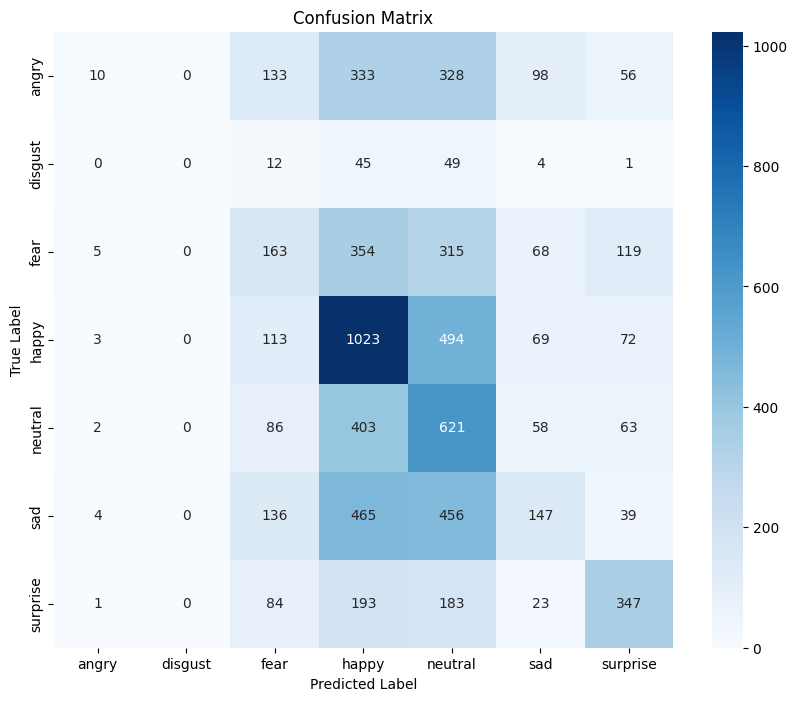

In [24]:
# STEP 13: Classification report (optional)
# 💡 STEP 13: Classification report and Confusion Matrix (Fixed)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# FER2013 classes
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

y_true = []
y_pred = []

for images, labels in val_dataset:
    # Labels are integers — no need to argmax
    true_labels = labels.numpy()

    # Predict probabilities
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Optional: Check what labels are actually present
present_labels = np.unique(np.concatenate([y_true, y_pred]))

print("\n✅ Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=present_labels,
    target_names=[class_names[i] for i in present_labels]
))

# 📊 Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in present_labels],
            yticklabels=[class_names[i] for i in present_labels])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()